# Simple Steps to Train Your Neural Network

- Step 1: Problem Definition
    - Input $x$
    - Output $y$
- Step 2: Data Preparation
    - Download and Formatting Data: torch.utils.data.Dataset, torch.utils.data.DataLoader
    - Data Preprocessing: torchvision.transforms
- Step 3: Model Architecture Design $f$
    - torch.nn (Example: 2-Layer Neural Network)
- Step 4: Loss Function Design $l(f(x), y)$
    - torch.nn.functional (Example: CrossEntropyLoss)
- Step 5: Optimizer Selection $\min l(f(x), y)$
    - torch.optim (Example: mini-batch SGD)
- Iteration:
    - Step 7: Train the Neural Network
        - Convergence, Loss curve  
    - Step 8: Validate the Model
        - Train / Validation / Test
    - Step 9: Evaluate the Model
        - Accuracy
    - Step 10: Model Tuning, Break if Got an Ideal Model
        - Tuning hyperparameters

## Step 1: Problem Definition

Image Classification:

Input: 
- modality: image
- datatype: uint8
- shape:(224, 224, 3)
- ranging: [0, 255]

Output: 
- label: car, frog, ..., N classes
- datatype: long
- shape: (1,)
- ranging: [0, N-1]

## Step 2: Prepare the Data

recall that you have already used the `trainset` and `testset` in your assignment1:

In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 设置 matplotlib 显示格式
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # 设置默认图像大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# CIFAR-10 数据集的下载和加载
transform = transforms.Compose(
    [transforms.ToTensor(),  # 转换为 Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化
)

In [27]:
from torch.utils.data import Dataset, DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
class OursDatasetwithTransforms(Dataset):
    def __init__(self, data, labels, transforms):
        """
        初始化数据集
        data: 输入数据，例如一个 NumPy 数组或 PyTorch 张量
        labels: 对应的标签
        """
        self.data = data
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        # 每个Dataset都必须写，返回数据集的大小
        return len(self.data)

    def __getitem__(self, idx):
        # 每个Dataset都必须写，获取指定索引idx的数据和标签
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transforms(sample)
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        
transform = transforms.Compose(
    [transforms.ToTensor(),  # [0, 255], PIL Image / ndarray --> [0, 1], torch.tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化, (input[channel] - mean[channel]) / std[channel]
)
traindata = trainset.data[:5000]
trainlabels = trainset.targets[:5000]
testdata = testset.data[:500]
testlabels = testset.targets[:500]

# 初始化自定义数据集
trainset = OursDatasetwithTransforms(traindata, trainlabels, transform)
testset = OursDatasetwithTransforms(testdata, testlabels, transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=False, drop_last=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


# Step 3: Model Architecture Design

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple two-layer neural network
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_class):
        super(TwoLayerNN, self).__init__()
        # Flatten input 32*32*3 = 3072
        self.relu = nn.ReLU()  # Activation function
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First layer (input to hidden)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second layer (hidden to hidden)
        self.fc3 = nn.Linear(hidden_dim, num_class)  # Second layer (hidden to output)
    
    def forward(self, x):
        x = x.flatten(1)  # Flatten the image input
        x = self.fc1(x)  # First linear transformation
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc2(x)  # Second linear transformation
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc3(x)  # Second linear transformation
        return x

# Instantiate the model, loss function, and optimizer
input_dim = 32 * 32 * 3
hidden_dim = 100
num_class = 10
batch_size = 64
model = TwoLayerNN(input_dim, hidden_dim, num_class)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print('Parameters: ', [name for name, param in model.named_parameters()])
print('Trainable Parameters: {:.3f}M'.format(sum([param.numel() for param in model.parameters()])/ 1024 / 1024))

input_test = torch.randn(batch_size, 32, 32, 3).to(device)

output = model(input_test)
print(output.shape)



Parameters:  ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
Trainable Parameters: 0.304M
torch.Size([64, 10])


## An example to understand the concept of `model`, `training`, `loss`


suppose we have 50 `data` with 1 dimention, we want to design a function $f$ (we will call it a `model` in the next few months), such that the curve of function `fits` the data

observing the data curve, we easily identify that it could be perfect if the function is a `sin/cos(x)`. Therefore we define the function as:

$$f(x) = a\sin(bx+c) + d$$

and simply define a L2 penalty, when the function does not predict well (we will call it `loss`):

$$\min_{a,b,c,d}J(a,b,c,d)={(f(x) - y)^{2}}$$

here, a,b,c,d are `parameters`

How to `optimize` the `parameters` in order to minimize the loss?

Understanding Gradient descent via an Example:

at first, a,b,c,d are randomly initialized, therefore the loss is large, suppose the parameter-loss curve be like (not the real curve of our loss): 
<img src="./GD.png">

after optimizing the parameters through gradient descent, the function `diverges` in `local minima`

Specifically, the gradient is the derivative of the function, i.e., $\frac{\delta f}{\delta a}$.

Going along the direction of derivatives step by step, the gradient descent is formulated as:

$$ w_i = w_i - \alpha\cdot \frac{\delta J(w)}{\delta w}, w=[a,b,c,d]$$

the $\alpha$ is `learning rate`, determining the length that you update the parameters.

Here we have N samples, therefore the formula is actually calculated as:

$$ w_i = w_i - \alpha\cdot \frac{1}{N} \Sigma_{j=0}^{N} \frac{\delta J_j(w)}{\delta w}, w=[a,b,c,d]$$


variants of gradient descent:

we call the number of sample used in one update as `batch_size`

- Batch GD: update parameter using the whole training data
$$ w_i = w_i - \alpha\cdot \frac{1}{N} \Sigma_{j=0}^{N} \frac{\delta J_j(w)}{\delta w}, w=[a,b,c,d]$$
- Stochastic GD: update parameter using only one sample
$$ w_i = w_i - \alpha\cdot \frac{\delta J_j(w)}{\delta w}, w=[a,b,c,d]$$
- Mini-Batch GD: update parameter using a mini batch of sample
$$ w_i = w_i - \alpha\cdot \frac{1}{m} \Sigma_{j=0}^{m} \frac{\delta J_j(w)}{\delta w}, w=[a,b,c,d], m<N$$



Epoch 1: Step 1 Completed, Running Loss: 2.2979


C:\Users\charles0618\AppData\Local\Temp\ipykernel_17476\1048525845.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


train Accuracy: 31.42%
test Accuracy: 30.80%
Epoch [1/60] Completed, Avg Train Loss: 2.1301, Test Loss: 1.9661
Epoch 2: Step 1 Completed, Running Loss: 2.1452
train Accuracy: 38.60%
test Accuracy: 35.60%
Epoch [2/60] Completed, Avg Train Loss: 1.8402, Test Loss: 1.8345
Epoch 3: Step 1 Completed, Running Loss: 1.9344
train Accuracy: 41.82%
test Accuracy: 36.20%
Epoch [3/60] Completed, Avg Train Loss: 1.6867, Test Loss: 1.7857
Epoch 4: Step 1 Completed, Running Loss: 1.8276
train Accuracy: 45.82%
test Accuracy: 37.00%
Epoch [4/60] Completed, Avg Train Loss: 1.5841, Test Loss: 1.7678
Epoch 5: Step 1 Completed, Running Loss: 1.7049
train Accuracy: 50.02%
test Accuracy: 37.60%
Epoch [5/60] Completed, Avg Train Loss: 1.4870, Test Loss: 1.7547
Epoch 6: Step 1 Completed, Running Loss: 1.6106
train Accuracy: 54.14%
test Accuracy: 38.60%
Epoch [6/60] Completed, Avg Train Loss: 1.3963, Test Loss: 1.7427
Epoch 7: Step 1 Completed, Running Loss: 1.4905
train Accuracy: 57.14%
test Accuracy: 38.40%
E

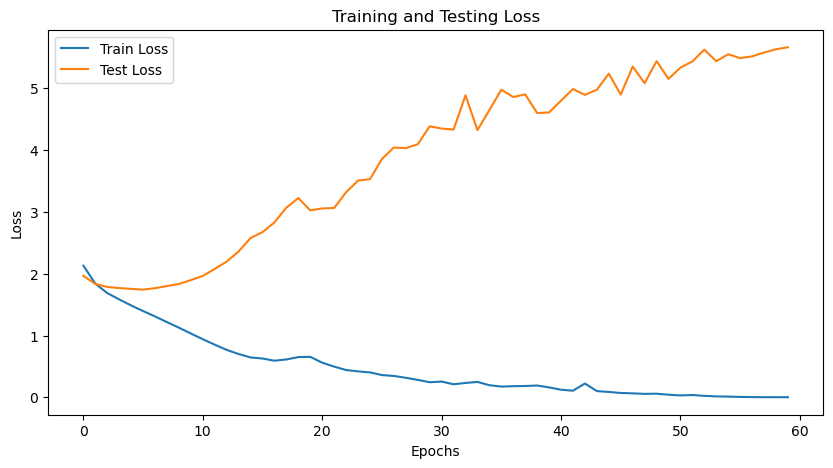

In [29]:
criterion = nn.CrossEntropyLoss()  # Since it's a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# 训练模型
def train_model(num_epochs, step=100):
    train_loss_history = []
    test_loss_history = []
    print_interval = step  # 每隔多少step打印一次损失
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        step_loss = 0.0
        ############## TODO ##############
        # 遍历 trainloader
        for step, data in enumerate(trainloader):
            # 把input和label放到对应device（cpu或cuda）
            x_train, y_train = data
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            # 清空优化器
            optimizer.zero_grad()
            # 模型前向传播
            y_pred = model(x_train)
            # 计算损失
            loss = criterion(y_pred, y_train)
            # 梯度反向传播
            loss.backward()
            # 利用优化器更新模型参数
            optimizer.step()
            # 更新train loss
            step_loss = loss.item()
            # 每隔一定step打印和记录损失
            running_loss += step_loss
            if step % (print_interval - 1) == 0:
                print(f"Epoch {epoch+1}: Step {step+1} Completed, Running Loss: {running_loss:.4f}")

        # 计算并记录每个epoch的训练损失
        epoch_loss = running_loss / len(trainloader)
        # 评估模型
        evaluate_model(trainloader, 'train')
        test_loss = evaluate_model(testloader, 'test')
        train_loss_history.append(epoch_loss)
        test_loss_history.append(test_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] Completed, Avg Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_loss_history, test_loss_history

# 评估模型
def evaluate_model(loader, info):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    # 阻止自动计算梯度
    with torch.no_grad():
        # 遍历loader
        for data in loader:
            # 把input和label放到对应device（cpu或cuda）
            x_test, y_test = data
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            # 前向传播
            y_pred = model(x_test)
            # 计算loss
            loss = criterion(y_pred, y_test)
            # 把loss的值更新到total loss里
            total_loss += loss.item()
            # 计算预测的标签     
            _, label_pred = torch.max(y_pred, 1)
            # 计算预测正确的标签    
            correct += (label_pred == y_test).sum().item()
            total += len(y_test)
        
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total

    print(f"{info} Accuracy: {accuracy:.2f}%")
    return avg_loss

# 绘制损失曲线
def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Testing Loss')
    plt.show()

# 训练并评估模型
num_epochs = 60
train_loss, test_loss = train_model(num_epochs)

# 绘制损失曲线
plot_loss(train_loss, test_loss)

Impact of:
- Larger model size (More hidden state each layer; More layers)
- Different optimizer (e.g. torch.optim.Adam, torch.optim.AdamW)
- Novel architecture (e.g., Dropout, BatchNormalization, etc.)
- Weight initialization (e.g. xavier)
- Novel loss / regularization (e.g. l2)
- hyper-parameters (e.g. Batchsize, learning rate, etc.)

a playground by Google: https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-gauss&learningRate=0.03&regularizationRate=0&noise=0&networkShape=5,2,2&seed=0.07966&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false
